In [19]:
import json
import pyrender
import trimesh
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image, ImageDraw
from car_models import car_id2name, car_name2id
import cv2
import os
import sys
sys.path.append("../wlevel_estimator/")

fx=2304.54786556982
fy=2305.875668062
cx=1686.23787612802
cy=1354.98486439791



camera_matrix = np.array([[fx, 0,  cx],
                          [0,  fy, cy],
                          [0,  0,  1 ]], dtype=np.float32)

dist_coeffs = np.zeros((1,4))

In [20]:
kayan_id = car_name2id["baoshijie-kayan"].id

filePath = "D:\\Program\\Apollo\\instance\\train\\car_poses\\"
file_names = os.listdir(filePath)

the_file_name = ""
the_car_id = 0

for file_name in file_names:
    with open(filePath+file_name,"r+") as f:
        car_poses = json.load(f)

        car_found = False

        for i,car_pose in enumerate(car_poses):
            if car_pose['car_id'] == kayan_id:
                the_file_name = file_name
                the_car_id = i
                print(file_name)
                print(i)
                car_found = True
                break

        if car_found:
            break

base_name = os.path.splitext(the_file_name)[0]

171206_034625454_Camera_5.json
0


In [35]:
image_path = "D:\\Program\\Apollo\\instance\\train\\images\\"
pose_path = "D:\\Program\\Apollo\\instance\\train\\car_poses\\"

pil_image = Image.open(image_path+base_name+".jpg")
width, height = pil_image.size
np_image = np.array(pil_image)

with open(pose_path+the_file_name,"r") as file:
    car_poses = json.load(file)



In [85]:
car_pose = car_poses[the_car_id]
id = car_pose['car_id']
car_name = car_id2name[id].name
roll,pitch,yaw,x,y,z = car_pose['pose']

with open("../car_models_json/"+car_name+".json","r") as file:
    car_model = json.load(file)
    vertices = car_model['vertices']
    faces_array = np.array(car_model['faces']) - 1
    faces = faces_array.tolist()
    car_trimesh = trimesh.Trimesh(vertices = vertices, faces = faces)
    car_trimesh.export("../mesh/"+car_name+".obj")

with open("car.obj","w") as file:
    file.write("# test.obj\n")
    for v in vertices:
        file.write("v "+str(("%.8f" % v[0]))+" "+str(("%.8f" % v[1]))+" "+str(("%.8f" % v[2]))+"\n")

    for f in faces:
        file.write("f "+str(f[0])+" "+str(f[1])+" "+str(f[2])+"\n")

In [44]:
roll,pitch,yaw,x,y,z = car_pose['pose']
x,y,z 

(4.19093, 3.48249, 10.4831)

In [53]:
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])        
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])     
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
    R = np.dot(R_z, np.dot( R_y, R_x ))

    return R

def createHomogenousMatrix(pitch,yaw,roll,x,y,z):
    R = eulerAnglesToRotationMatrix([pitch,yaw,roll])
    T = np.array([[x,y,z]])
    RT = np.hstack((R,T.T))
    return np.vstack((RT,[0.0,0.0,0.0,1.0]))

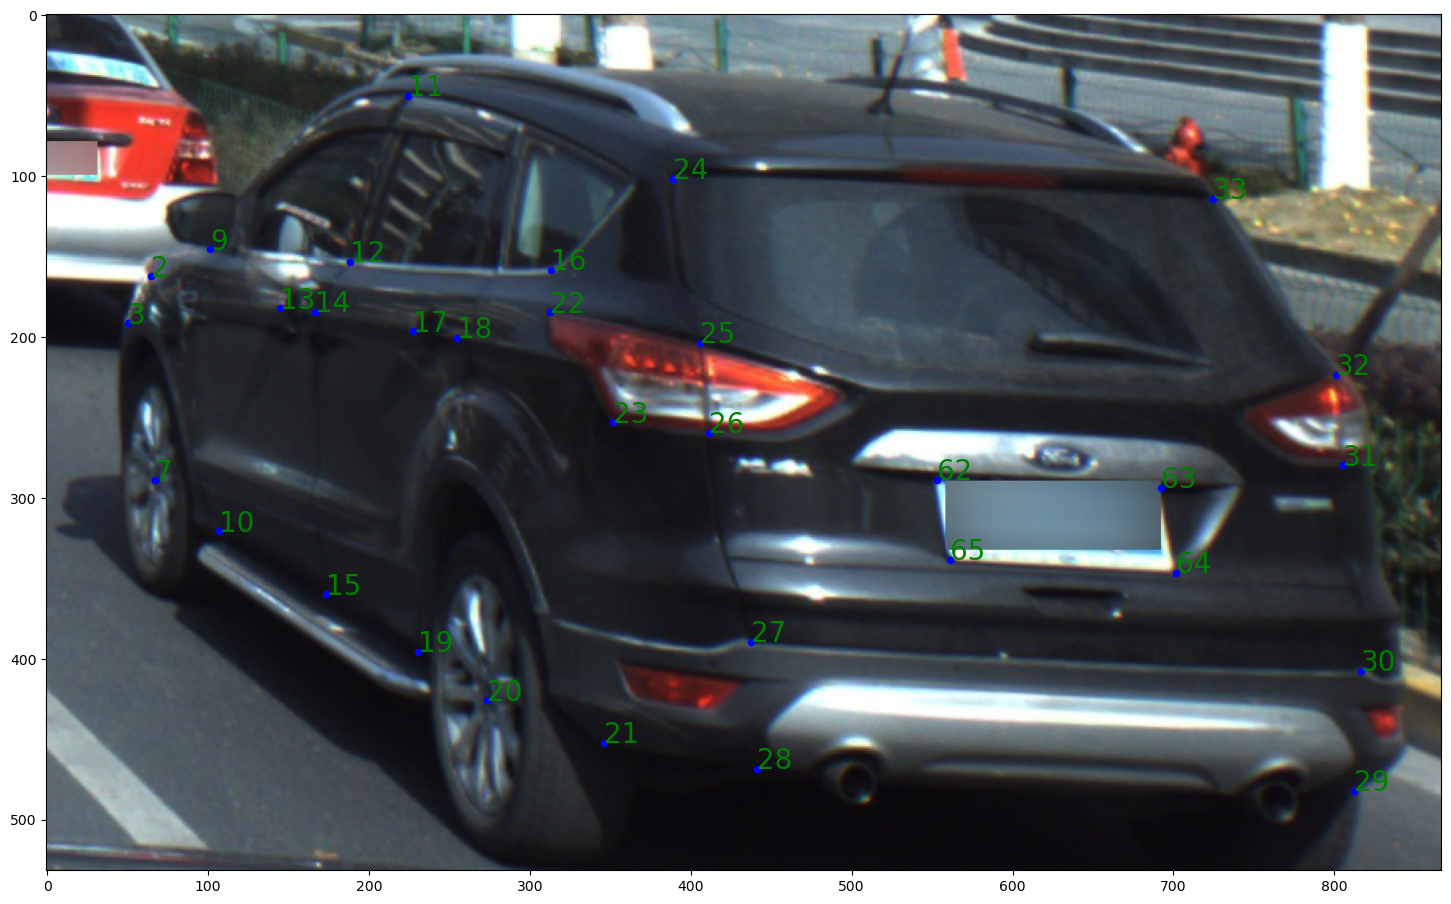

In [78]:
%matplotlib inline
keypoint_path = "D:\\Program\\Apollo\\instance\\train\\keypoints\\"

keypoint = []
kpt_visable_id = []
with open(keypoint_path+base_name+"\\"+base_name+"_"+str(the_car_id).zfill(4)+".txt","r") as file:
    for line in file.readlines():
        line = line.strip('\n')
        kpt_id,x,y = line.split()
        kpt_visable_id.append(kpt_id)
        keypoint.append([float(x),float(y)])

keypoints_2D = np.array(keypoint,dtype='float64')
kpt_visable_id = np.array(kpt_visable_id,dtype='int')

x_min = np.min(keypoints_2D[:,0])-50
x_max = np.max(keypoints_2D[:,0])+50
y_min = np.min(keypoints_2D[:,1])-50
y_max = np.max(keypoints_2D[:,1])+50

crop_image = pil_image.crop((x_min, y_min, x_max, y_max))

keypoint_2D_crop = keypoints_2D.copy()

for i in range(len(keypoint_2D)):
    keypoint_2D_crop[i,0] = keypoint_2D_crop[i,0]-x_min
    keypoint_2D_crop[i,1] = keypoint_2D_crop[i,1]-y_min

plt.figure(figsize=(18,16))
for kpt_id,kpt in zip(kpt_visable_id,keypoint_2D_crop):

    x = kpt[0]
    y = kpt[1]

    plt.scatter(x,y,c='blue', s=20)
    plt.text(x, y, kpt_id,color = "green",fontsize=20)
plt.imshow(crop_image)
plt.show()

In [111]:
the_car_id

0

In [79]:
with open("../mesh/"+car_name+"_keypts.txt") as file:
    keypoints_3D_all = []
    
    for line in file.readlines():
        line = line.strip('\n')
        x,y,score = line.split()
        keypoints_3D_all.append(line.split())

keypoints_3D_24_ndarray = np.array(keypoints_3D_all)
keypoints_3D = keypoints_3D_24_ndarray[kpt_visable_id].tolist()


objPoints = np.array(keypoints_3D,dtype='float64')
imgPoints = np.array(keypoints_2D,dtype='float64')

(_, rotation_vector, translation_vector,_) = cv2.solvePnPRansac(objPoints,
                                                            imgPoints,
                                                            camera_matrix,
                                                            dist_coeffs,
                                                            flags=cv2.SOLVEPNP_EPNP
                                                            )

In [108]:
rotM,_ = cv2.Rodrigues(rotation_vector)

# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    assert(isRotationMatrix(R))
 
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
 
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

new_pitch,new_yaw,new_roll = rotationMatrixToEulerAngles(rotM)

In [109]:
new_pitch,new_yaw,new_roll

(-0.20466852372490293, 0.013650923866112299, 0.02307587092893627)

In [110]:
pitch,yaw,roll

(-0.0632802, -3.02277, 0.202539)

In [103]:
rotation_matrix = eulerAnglesToRotationMatrix([-yaw,-pitch,-roll])
rotation_vector_from_pose,_ = cv2.Rodrigues(rotation_matrix)
rotation_vector_from_pose

array([[ 3.01276487],
       [-0.3004191 ],
       [-0.1135444 ]])

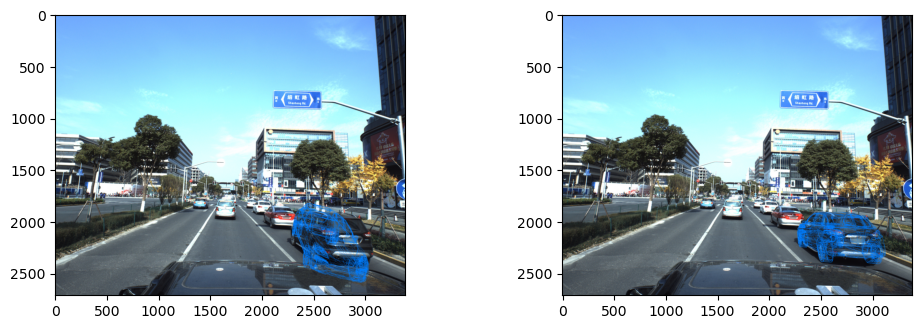

In [105]:
%matplotlib inline
def draw_obj(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.polylines(image, np.int32([coord]), 1, color)
        
def draw_obj_mask(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.fillPoly(image, np.int32([coord]),  color)

translation_vector_from_pose = np.array(([x],[y],[z]),dtype='float64')
rotation_matrix = eulerAnglesToRotationMatrix([pitch,yaw,roll])
rotation_vector_from_pose,_ = cv2.Rodrigues(rotation_matrix)

all_points = np.array(vertices,dtype='float64')

(projected_points_from_pose, jacobian_model) = cv2.projectPoints(all_points, 
                                                            rotation_vector_from_pose, 
                                                            translation_vector_from_pose,
                                                            camera_matrix, 
                                                            dist_coeffs)

draw_image_pose = np_image.copy()

draw_obj(draw_image_pose,projected_points_from_pose,faces,(0, 125, 255))

(projected_points, jacobian_model) = cv2.projectPoints(all_points, 
                                                            rotation_vector, 
                                                            translation_vector,
                                                            camera_matrix, 
                                                            dist_coeffs)

draw_image = np_image.copy()

draw_obj(draw_image,projected_points,faces,(0, 125, 255))

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(draw_image_pose)
plt.subplot(2,2,2)
plt.imshow(draw_image)
plt.show()

In [62]:
fx,fy,cx,cy

(2304.54786556982, 2305.875668062, 1686.23787612802, 1354.98486439791)

### PNP

In [60]:
%matplotlib inline
with open("../mesh/"+car_name+"_keypts.txt") as file:
    keypoints_str = []
    
    for line in file.readlines():
        line = line.strip('\n')
        x,y,score = line.split()
        keypoints_str.append(line.split())
        keypoints_3D = np.array(keypoints_str,dtype='float64')

valid_index = np.array(kpt_visable_id,dtype='int')

objPoints = keypoints_3D[valid_index]
imgPoints = keypoint_2D

(retval, rotation_vector, translation_vector) = cv2.solvePnP(objPoints,
                                                        imgPoints,
                                                        camera_matrix,
                                                        dist_coeffs,
                                                        useExtrinsicGuess=False,flags=cv2.SOLVEPNP_EPNP
                                                        )

(projected_keypoints, jacobian_model) = cv2.projectPoints(objPoints, 
                                                                rotation_vector, 
                                                                translation_vector,
                                                                camera_matrix, 
                                                                dist_coeffs)

plt.figure(figsize=(18,16))
for kpt_id,kpt in zip(kpt_visable_id,keypoint):
    plt.scatter(int(kpt[0]),int(kpt[1]),c='yellow', s=10)
    plt.text(int(kpt[0]), int(kpt[1]), kpt_id,color = "indigo",fontsize=10)
plt.imshow(pil_image)
plt.show()

### Render

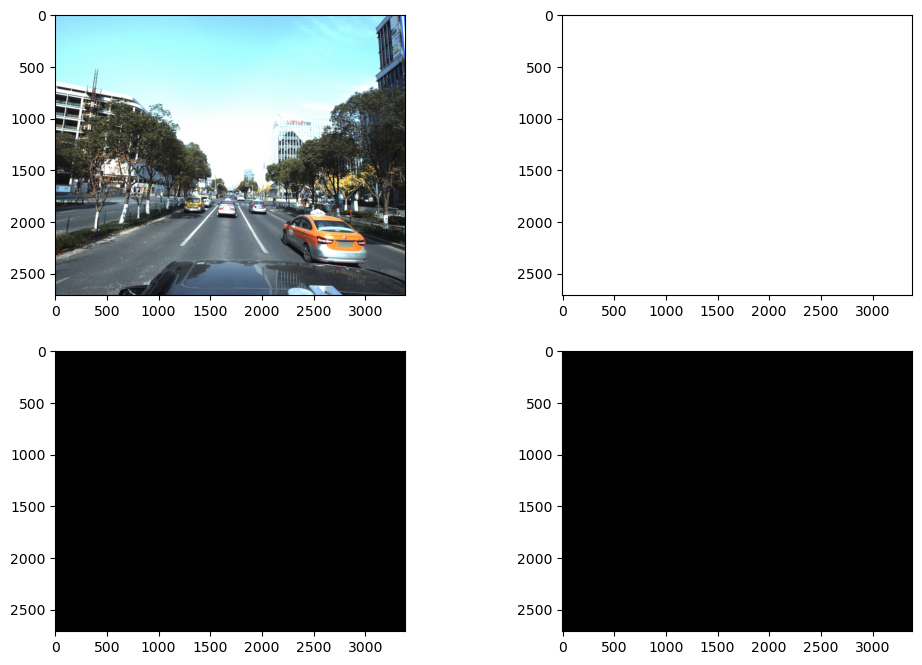

In [16]:
%matplotlib inline
# 2d visualization
show_image = pil_image.copy()
P = np.array([x,y,z]).T
img_p = np.dot(camera_matrix, P).T
img_p[0] /= img_p[2]
img_p[1] /= img_p[2]
img_xs = img_p[0]
img_ys = img_p[1]

imagedraw = ImageDraw.Draw(show_image)
r = 50
imagedraw.ellipse(((img_xs-r,img_ys-r),(img_xs+r,img_ys+r)),fill=(255, 0, 0))

#create new scene
scene = pyrender.Scene()

# add new camera to the scene
camera = pyrender.IntrinsicsCamera(fx,fy,cx,cy)
camera_pose = createHomogenousMatrix(0.0,0.0,0.0,0.0,0.0,0.0)
scene.add(camera, pose=camera_pose)

# add new light to the scene
light = pyrender.SpotLight(color=np.array([0.0,1.0,0.0]), intensity=100.0,
                            innerConeAngle=np.pi/16.0,
                            outerConeAngle=np.pi/2.0)
scene.add(light, pose=camera_pose)

# add object mesh to the scene
mesh = pyrender.Mesh.from_trimesh(car_trimesh)
mesh_pose = createHomogenousMatrix(yaw,-roll,pitch,x,-y,-z)
scene.add(mesh,pose=mesh_pose)

# offscreen render the scene
r = pyrender.OffscreenRenderer(width, height)
color, depth = r.render(scene)

mask = np.zeros((height,width))
mask[depth > 0] = 1
mask_3 = np.expand_dims(mask, axis=2)
mask_3 = np.concatenate((mask_3, mask_3, mask_3), axis=-1)
image_maskd = np.where(mask_3, np_image, 0)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(show_image)
plt.subplot(2,2,2)
plt.imshow(color)
plt.subplot(2,2,3)
plt.imshow(image_maskd)
plt.subplot(2,2,4)
plt.imshow(mask_3,cmap="binary")
plt.show()

In [22]:
import pandas as pd

data = pd.read_csv('../mesh/test.csv')
for row in data.iterrows():
    image_id = row[1].ImageId
    pred_string = row[1].PredictionString
    
    items = pred_string.split(' ')
    model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]
    if '51' in model_types:
        print(image_id)
        break

ID_a381bf4d0


In [5]:
data.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [21]:
kayan_id

51